Code from: https://www.kaggle.com/philschmidt/cervix-eda-model-selection

Import libraries and packages:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.io import imread, imshow
import cv2 # first I needed to run following command: sudo pip3 install opencv-python

%matplotlib inline
import plotly.offline as py # first I needed to run following command: pip install plotly
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

from subprocess import check_output
from glob import glob

Print files in current directory (gives you list of labels, since the images are organized by label directory!):

In [2]:
print(check_output(["ls", "sample_train_cervix_shapes"]).decode("utf8"))

Type1
Type2
Type3



Create dataframe where you have each image path, file type and label:

In [5]:
basepath = 'sample_train_cervix_shapes/'

all_cervix_images = []

for path in sorted(glob(basepath + "*")): # iterate through each directory (ie each type)
    cervix_type = path.split("/")[-1] # gives you the type (ie directory) of current instance
    cervix_images = sorted(glob(basepath + cervix_type + "/*")) # gives you all images in current directory,
        # in the following format: sample_train_cervix_shapes/Type1/image_number.jpg
    all_cervix_images = all_cervix_images + cervix_images # list of all of the images in same format as previous!
    
all_cervix_images = pd.DataFrame({'imagepath': all_cervix_images})
all_cervix_images['filetype'] = all_cervix_images.apply(lambda row: row.imagepath.split(".")[-1], axis=1)
all_cervix_images['type'] = all_cervix_images.apply(lambda row: row.imagepath.split("/")[-2], axis=1)
all_cervix_images.head()

,imagepath,filetype,type
0,sample_train_cervix_shapes/Type1/191.jpg,jpg,Type1
1,sample_train_cervix_shapes/Type1/201.jpg,jpg,Type1
2,sample_train_cervix_shapes/Type1/205.jpg,jpg,Type1
3,sample_train_cervix_shapes/Type1/208.jpg,jpg,Type1
4,sample_train_cervix_shapes/Type1/215.jpg,jpg,Type1


Count how many images per label:

We have a total of 60 images in the whole dataset


Text(0.5, 0, 'training size fraction')

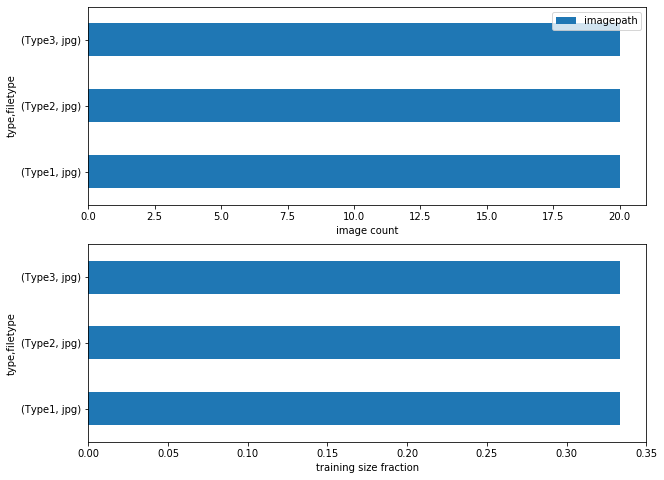

In [6]:
print('We have a total of {} images in the whole dataset'.format(all_cervix_images.shape[0]))
type_aggregation = all_cervix_images.groupby(['type', 'filetype']).agg('count')
type_aggregation_p = type_aggregation.apply(lambda row: 1.0*row['imagepath']/all_cervix_images.shape[0], axis=1)

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

type_aggregation.plot.barh(ax=axes[0])
axes[0].set_xlabel("image count")
type_aggregation_p.plot.barh(ax=axes[1])
axes[1].set_xlabel("training size fraction")

Visualize each type of cervix:

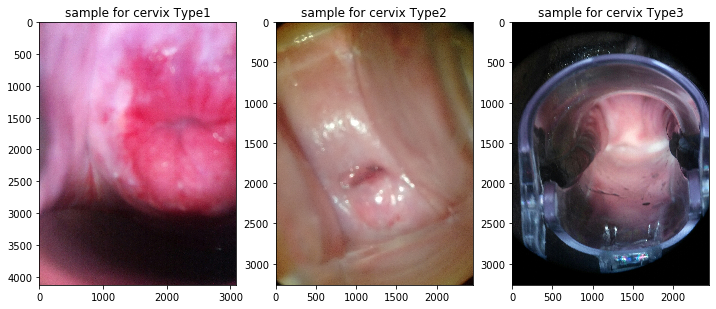

In [9]:
fig = plt.figure(figsize=(12,8))

i = 1
for t in all_cervix_images['type'].unique():
    ax = fig.add_subplot(1,3,i)
    i+=1
    f = all_cervix_images[all_cervix_images['type'] == t]['imagepath'].values[0]
    plt.imshow(plt.imread(f))
    plt.title('sample for cervix {}'.format(t))

Getting all the image dimensions:

In [14]:
from collections import defaultdict

images = defaultdict(list)

for t in all_cervix_images['type'].unique():
    sample_counter = 0
    for _, row in all_cervix_images[all_cervix_images['type'] == t].iterrows():
        #print('reading image {}'.format(row.imagepath))
        try:
            img = imread(row.imagepath)
            sample_counter +=1
            images[t].append(img)
        except:
            print('image read failed for {}'.format(row.imagepath))
        if sample_counter > 35:
            break
dfs = []
for t in all_cervix_images['type'].unique():
    t_ = pd.DataFrame(
        {
            'nrows': list(map(lambda i: i.shape[0], images[t])),
            'ncols': list(map(lambda i: i.shape[1], images[t])),
            'nchans': list(map(lambda i: i.shape[2], images[t])),
            'type': t
        }
    )
    dfs.append(t_)

shapes_df = pd.concat(dfs, axis=0)
shapes_df_grouped = shapes_df.groupby(by=['nchans', 'ncols', 'nrows', 'type']).size().reset_index().sort_values(['type', 0], ascending=False)
shapes_df_grouped.head(10)

/Users/nadiablostein/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:770: UserWarning:

Possibly corrupt EXIF data.  Expecting to read 524288 bytes but only got 0. Skipping tag 3

/Users/nadiablostein/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:770: UserWarning:

Possibly corrupt EXIF data.  Expecting to read 393216 bytes but only got 0. Skipping tag 3

/Users/nadiablostein/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:770: UserWarning:

Possibly corrupt EXIF data.  Expecting to read 33554432 bytes but only got 0. Skipping tag 4

/Users/nadiablostein/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:770: UserWarning:

Possibly corrupt EXIF data.  Expecting to read 25165824 bytes but only got 0. Skipping tag 4

/Users/nadiablostein/miniconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:770: UserWarning:

Possibly corrupt EXIF data.  Expecting to read 131072 bytes but only got 0. Skipping tag 3

/Users/nadiablostein/minic

,nchans,ncols,nrows,type,0
2,3,2448,3264,Type3,14
5,3,3096,4128,Type3,6
4,3,3096,4128,Type2,10
1,3,2448,3264,Type2,9
6,3,3120,4160,Type2,1
3,3,3096,4128,Type1,15
0,3,2448,3264,Type1,5


"All of the images in our sample have three channels, we can ignore this information for now. Now lets build a barplot to get an idea of the distribution of image dimensions by cervix type: "

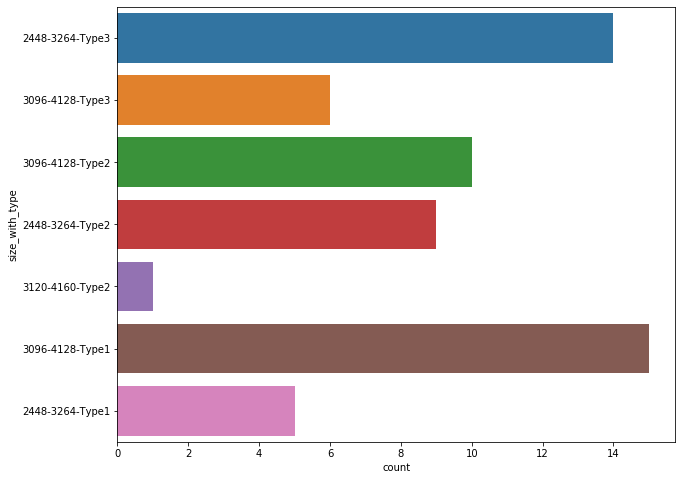

In [13]:
shapes_df_grouped['size_with_type'] = shapes_df_grouped.apply(lambda row: '{}-{}-{}'.format(row.ncols, row.nrows, row.type), axis=1)
shapes_df_grouped = shapes_df_grouped.set_index(shapes_df_grouped['size_with_type'].values)
shapes_df_grouped['count'] = shapes_df_grouped[[0]]

plt.figure(figsize=(10,8))
#shapes_df_grouped['count'].plot.barh(figsize=(10,8))
sns.barplot(x="count", y="size_with_type", data=shapes_df_grouped)